# AnimeGM - Convolutional Autoencoder
GOAL: Generate new anime-style images
    
Methodology:
1. Build a dataset of images suitable for out needs
2. Build a generative model.
3. Train the model
4. Generate a new image with random numbers
5. Transfer style to a photo
6. Examine results

## 1. Build a dataset
Pull in an existing dataset and modify it for my needs.

Lets start with the danbooru 2017 anime image dataset. Now this dataset is huge. So we are only going to use 1 torrent of the SFW subset.

### Imports

In [1]:
import pandas as pd
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import seaborn as sns; sns.set()
from skimage.transform import resize
from os import listdir
from os.path import join
from skimage import data
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
%matplotlib inline

### Functions

In [2]:
# tf image preprocessing
# load, decoded and resize
def parse_image(image_path):
    image_string = tf.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_grayscaled = tf.image.rgb_to_grayscale(image_decoded)
    image_resized = tf.image.resize_images(image_grayscaled, [resize_dim, resize_dim])
    return image_resized

In [3]:
def show_image(image):
    image_reshape = image.reshape((resize_dim, resize_dim))
    plt.imshow(image_reshape, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
def show_images(images, figsize=(10, 10)):
   # get the number of images
    n_images = images.shape[0]
    
    if n_images == 1:
        show_image(images[0])
        return
    
    # get the square root of the number of images
    squareroot = int(np.ceil(np.sqrt(n_images)))
    
    fig, ax = plt.subplots(squareroot, squareroot, figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, axi in enumerate(ax.flat):
        # exit if the index of subplots is greater than amount of images
        if i > n_images - 1:
            return
        image_reshape = images[i].reshape((resize_dim, resize_dim))
        im = axi.imshow(image_reshape, cmap='gray')

### Variables

In [5]:
dir_name = 'danbooru-small'

In [6]:
n_train = 2200
n_test = 10

resize_dim = 64
n_features = resize_dim * resize_dim

In [7]:
# hyper parameters~~~~
batch_size = 100
n_batches = int(n_train / batch_size)
n_epochs = 20
n_filters = [100, 100, 100]
filter_sizes = [3, 3, 3]

### Prepare data

This generative model will also substract the mean image from the dataset so lets get that

In [8]:
# get filenames and join paths as np array
base_filenames = listdir(dir_name)
filename_paths = [join(dir_name, base_filename) for base_filename in base_filenames]
filename_paths = np.array(filename_paths)

In [9]:
# create paths for train and test
train_paths = filename_paths[:-n_test][:n_train]
test_paths= filename_paths[:n_test]

In [10]:
# reset the current graph and start over
reset_default_graph()

In [11]:
# create a dataset from the paths
image_paths = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(parse_image)
dataset = dataset.shuffle(buffer_size=n_train)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

# iterators
iter = dataset.make_initializable_iterator()
next_ele = iter.get_next()

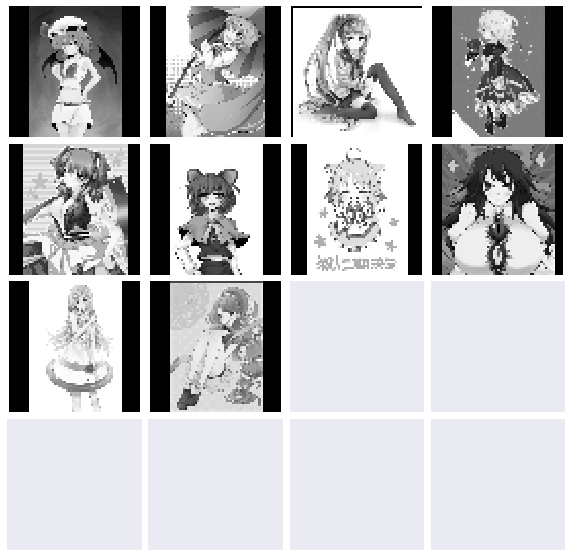

In [12]:
# Take a look at 1 batch
sess = tf.Session()

# Initialize an iterator over a dataset with 10 elements.
sess.run(iter.initializer, feed_dict={image_paths: test_paths})
images = sess.run(next_ele)

show_images(images)

## 2. Build a generative model
Lets build a convolutional autoencoder. While the idea is similar to the autoencoder, we are going to try to account for whats happening around pixels as opposited to just the pixel to pixel difference.

Previously, our input was an image [64px, 64px] of some number of samples:
`[n_samples, n_dim, n_dim]`

This was reshaped to be flattened so that we could feed the autoencoder with a long vector:
`[n_samples, n_dim * n_dim]`

Now we will use a 4-D tensor to preserve the relationship of the pixels:
`[n_samples, n_dim, n_dim, color_channel]`

In [13]:
# create a placeholder for inputs
X = tf.placeholder(tf.float32, [None, resize_dim, resize_dim, 1])

Instead of matrix operations, we ware going to create convolution operations.

We need to decide on filter size, and the number of filters, and number of layers

In [14]:
# Build the first half of the autoencoder which reduces dimensions at each layer
# copy X placeholder to current_input
current_input = X

# insteading of starting with the number of pixels, we will use the number of channels.
# this will help us find the first set of filters
n_input = 1

# create a list to store each matrix created
Ws = []
shapes = []

# loop over the list of n_filters and create a layer
# layer_i = index of current element
# n_output = element
for layer_i, n_output in enumerate(n_filters):
    # use variable scope to encapsulate variables
    # prefix all variables created in this scope
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # keep track of the shapes of each layer
        # we will use them in the decoder
        shapes.append(current_input.get_shape().as_list())
        
        # create a weight matrix which will reduce the amount of informations
        # in the input of each layer
        W = tf.get_variable(
                name='W',
                shape=[
                    filter_sizes[layer_i],
                    filter_sizes[layer_i],
                    n_input,
                    n_output
                ],
                initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        
        # convoluve the input with the shared wieght matrix
        h = tf.nn.conv2d(
                current_input,
                W,
                strides=[1, 2, 2, 1],
                padding='SAME')
        
        # use an activation function (RELU) on the output and set it to the input for the next layer
        current_input = tf.nn.relu(h)
        
        # store the weight matrix so that we can build the decoder
        Ws.append(W)
        
        # update the input dimensions with the current layer output
        n_input = n_output

At this point, we have the first half of the convolutional autoencoder. the input to the second half is at it's smallest dimensions. 

Additionally, the encoded weights are stored

This means it should be the size of the last element of the dimensions list

Build the next half of the convolutional autoencoder by increasing the dimensions at each layer back to the original

In [15]:
# reverse the order of the weight matrices
Ws.reverse()

# reverse the order of the shapes layer
shapes.reverse()

# reverse the number of filters
n_filters.reverse()

# append the laster filter size which is the original number of color channels
n_filters = n_filters[1:] + [1]

print(n_filters, shapes)

[100, 100, 1] [[None, 16, 16, 100], [None, 32, 32, 100], [None, 64, 64, 1]]


In [16]:
# loop over the list of filters and create a layer
# layer_i = index of current element
for layer_i, shape in enumerate(shapes):
    # use variable scope to encapsulate variables
    # prefix all variables created in this scope
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        
        # use the weight matrix from the encoder
        W = Ws[layer_i]
        
        # convolve the input with the weight matrix
        h = tf.nn.conv2d_transpose(
                current_input,
                W,
                tf.stack([
                    tf.shape(X)[0],
                    shape[1],
                    shape[2],
                    shape[3],
                ]),
                strides=[1, 2, 2, 1],
                padding='SAME')
        
        # use an activation function (RELU) on the output and set it to the input for the next layer
        current_input = tf.nn.relu(h)

In [17]:
# the current_input of the last layer is Y
Y = current_input

### Define cost function
Define the training signal.
This will be a cost function to measure the success of the network

In [18]:
# measure average difference across pixels
pixel_cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)

# measure mean across batches
cost = tf.reduce_mean(pixel_cost)

# use an Adam optimizer for training which tries to minimize cost
learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## 3. Train the model

In [19]:
# create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0 0 29650.15
0 1 30219.8
0 2 29145.418
0 3 30463.838
0 4 29762.855
0 5 28763.02
0 6 27538.908
0 7 28478.654
0 8 29932.195
0 9 30212.848
0 10 30250.828
0 11 30460.705
0 12 31017.346
0 13 30884.09
0 14 31489.412
0 15 29424.414
0 16 31866.902
0 17 29039.744
0 18 29187.744
0 19 28013.355
0 20 29884.9
0 21 29459.572
1 0 29831.832
1 1 28362.875
1 2 28854.62
1 3 29055.635
1 4 26992.14
1 5 27902.33
1 6 27555.723
1 7 27907.885
1 8 25728.4
1 9 26612.365
1 10 23369.225
1 11 22944.352
1 12 23556.336
1 13 22496.93
1 14 20053.576
1 15 19495.328
1 16 17821.883
1 17 17130.9
1 18 15695.956
1 19 15278.348
1 20 14595.38
1 21 15073.39
2 0 14961.624
2 1 15329.64
2 2 15407.972
2 3 15348.103
2 4 14401.253
2 5 13763.367
2 6 13458.2
2 7 12999.796
2 8 12128.549
2 9 12447.675
2 10 11978.478
2 11 12228.82
2 12 11503.443
2 13 12031.152
2 14 11569.381
2 15 10842.722
2 16 10491.387
2 17 10276.657
2 18 10054.541
2 19 9866.37
2 20 8753.202
2 21 9146.878
3 0 9238.416
3 1 8465.536
3 2 8582.256
3 3 7845.674
3 4 8289.544


C:\Users\Admin\Anaconda3\envs\jupyter\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


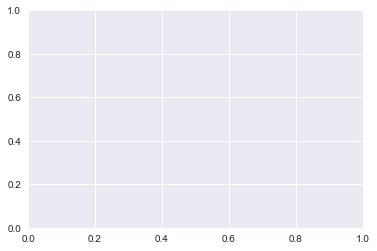

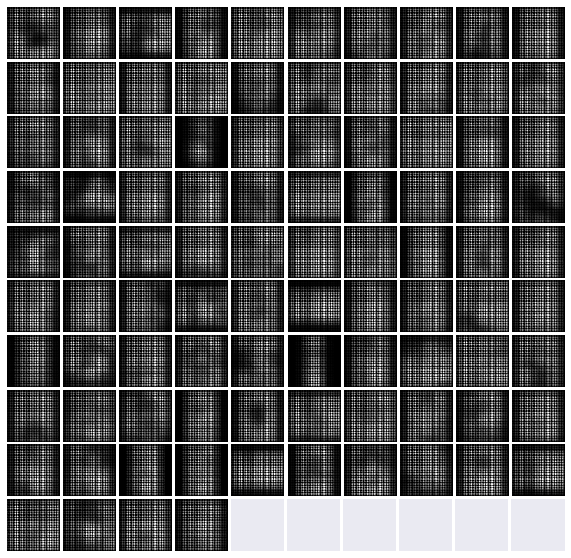

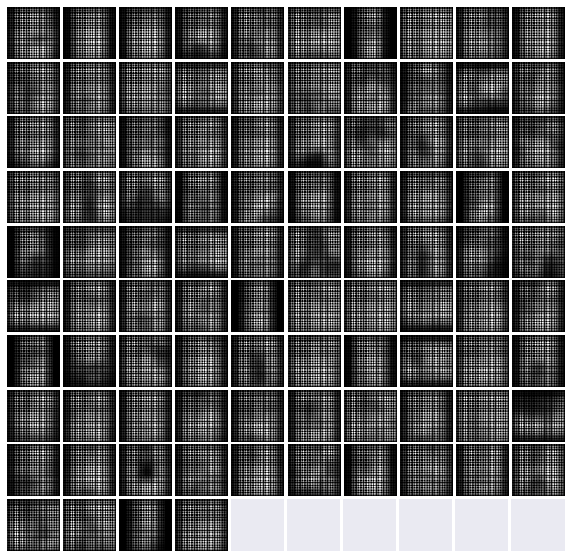

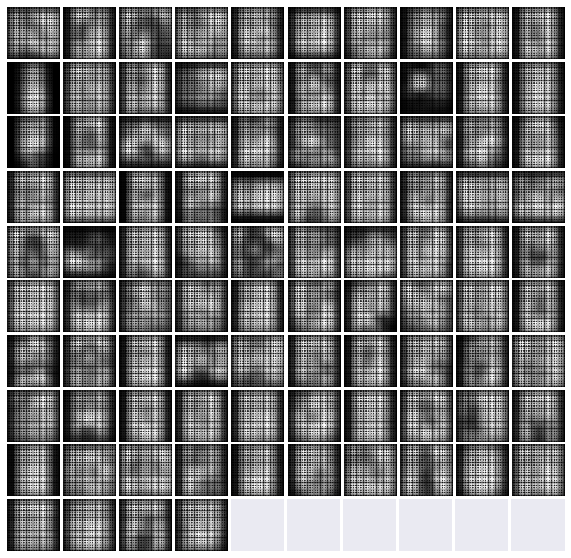

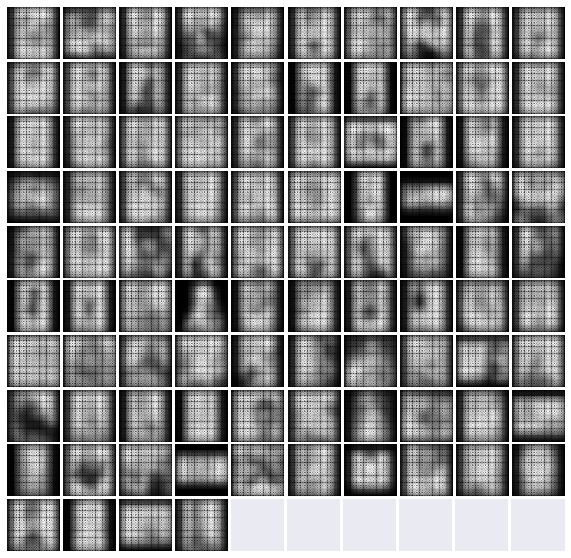

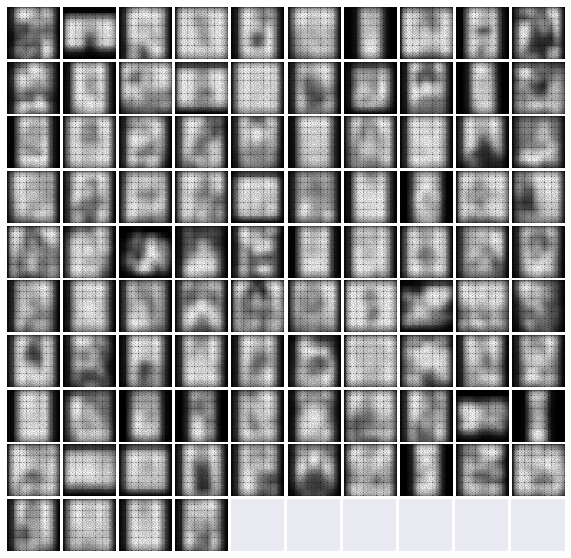

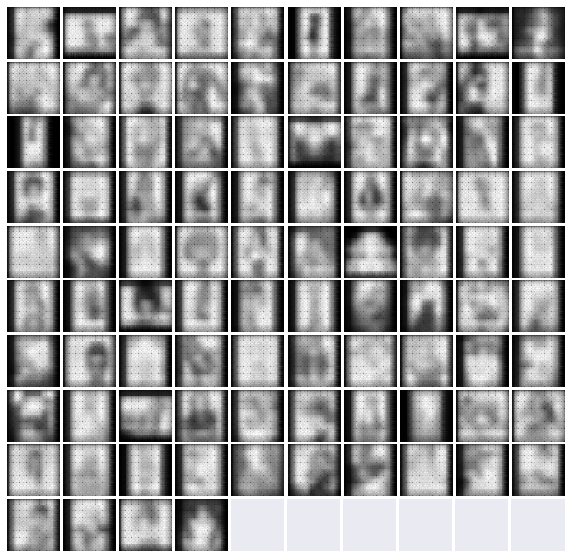

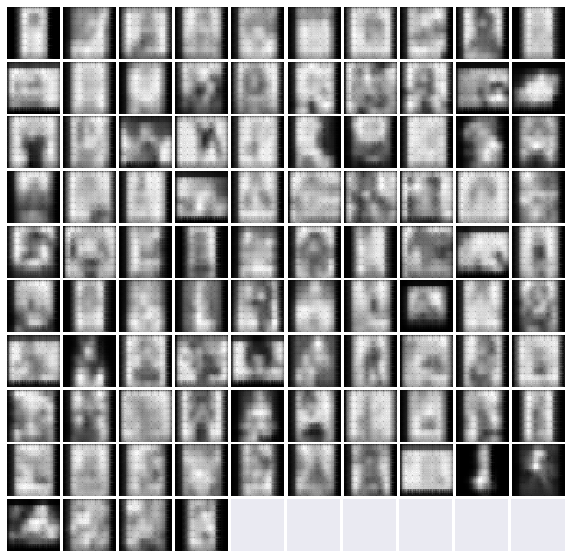

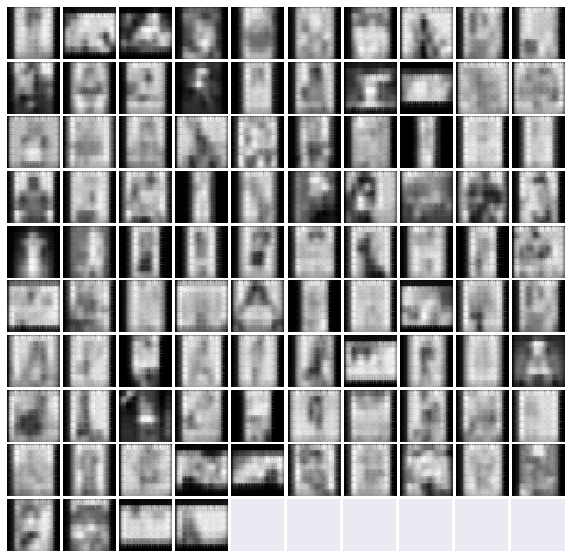

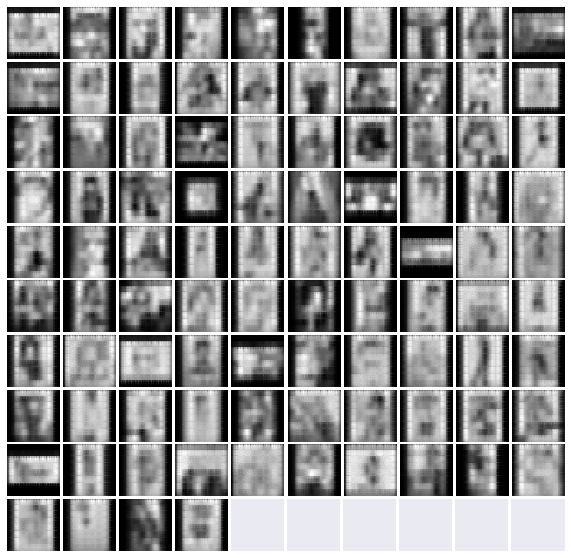

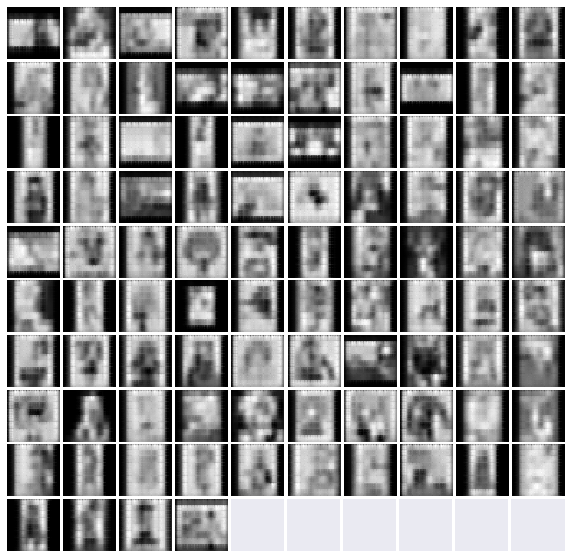

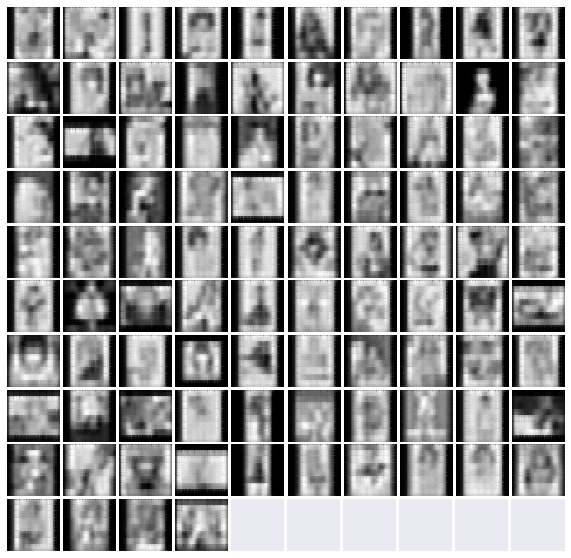

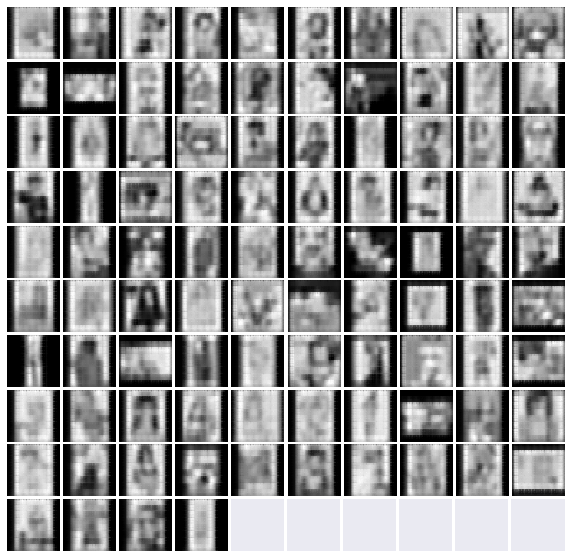

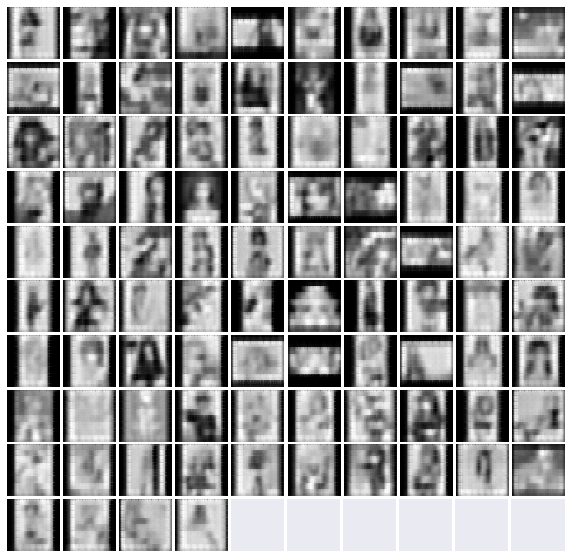

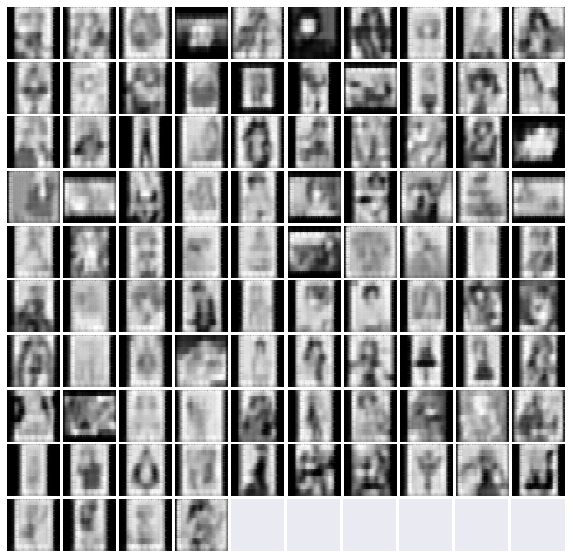

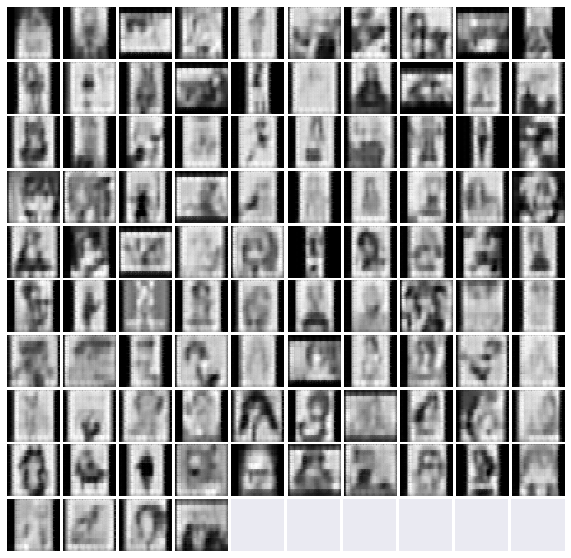

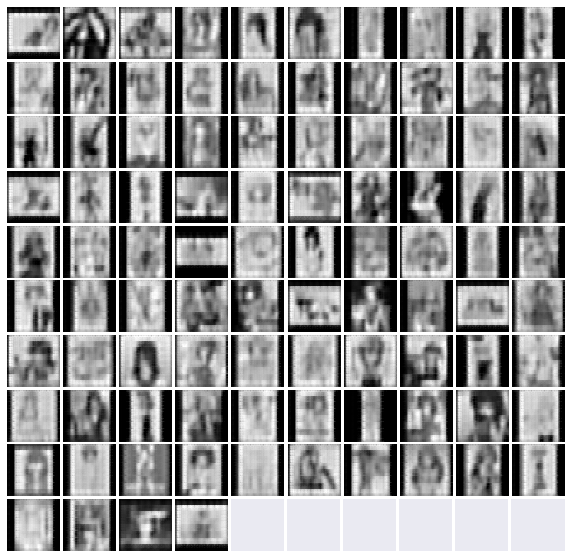

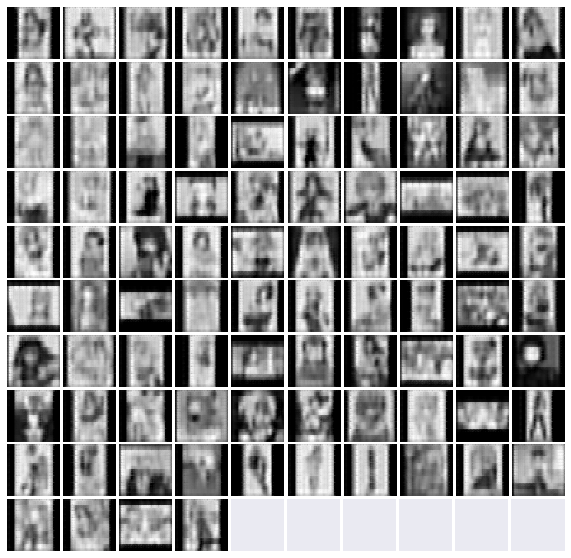

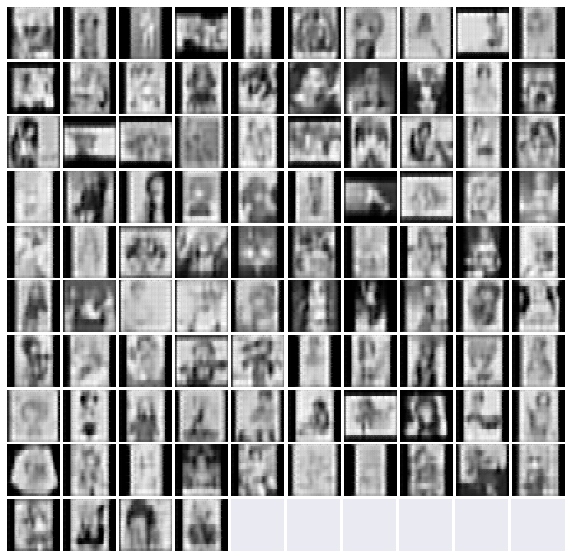

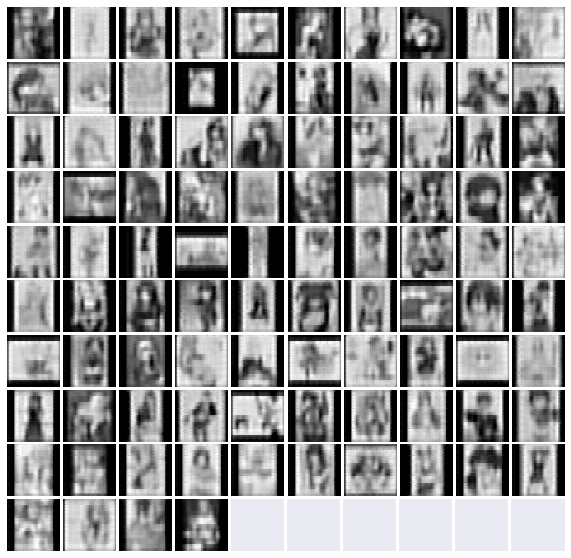

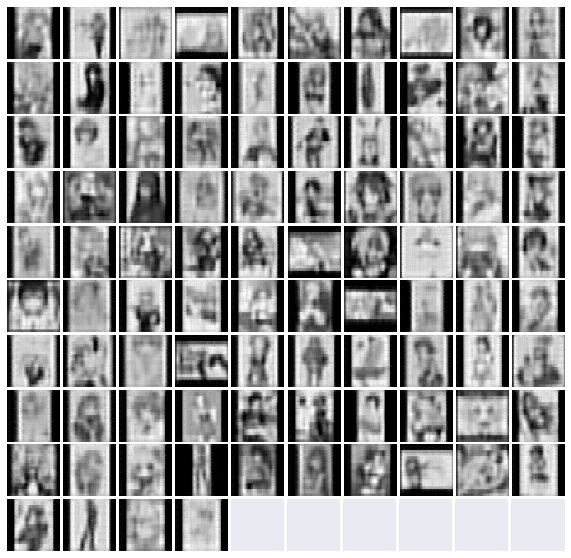

In [20]:
# train by running n batches for n epochs
fig, ax = plt.subplots(1, 1)

# Initialize an iterator over a dataset with 10 elements.
sess.run(iter.initializer, feed_dict={image_paths: train_paths})
    
for epoch_i in range(n_epochs):
    for batch_i in range(n_batches):
        # get batch
        batch_X = sess.run(next_ele)

        # train
        sess.run(optimizer, feed_dict={X: batch_X})

        # show cost per epoch
        print(epoch_i, batch_i, sess.run(cost, feed_dict={X: batch_X}))

    # reconstruct the test images
    reconstructed_test_images = sess.run(Y, feed_dict={X: batch_X})
    show_images(reconstructed_test_images)

## 4. Generate a new image
Use the trained model to generate a new image

In [21]:
# number of images to generate
n_new_images = 10

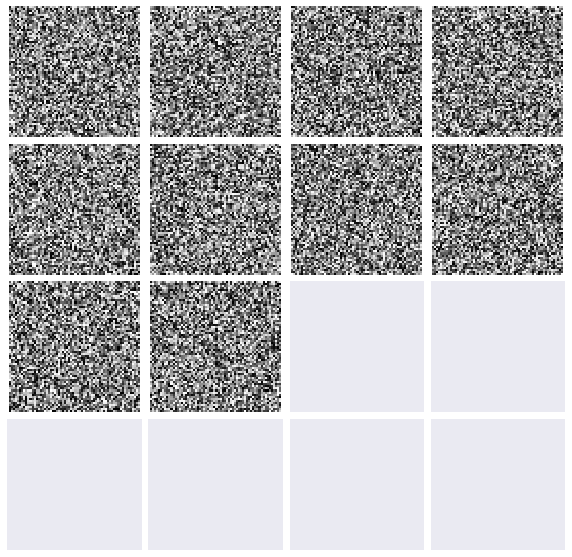

In [22]:
# generate using random numbers
np.random.RandomState(seed=0)
new_images = np.random.rand(n_new_images, resize_dim, resize_dim, 1)

# view the image
show_images(new_images)

### Reconstruct without normalizing against training dataset

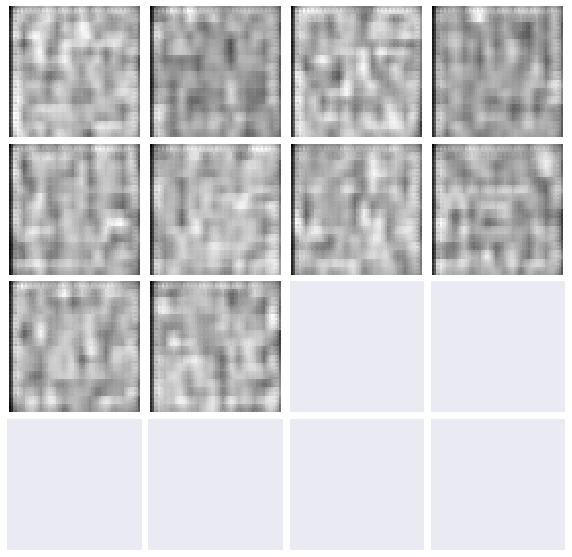

In [23]:
# reconstruct the example images
reconstructed_images = sess.run(Y, feed_dict={X: new_images})

# reshape them to the original shape and type
# reshaped_reconstructed_images = (reconstructed_images).reshape(-1, resize_dim, resize_dim)

# clip images to deal with saturation
clipped_image = np.clip(reconstructed_images, 0, 255)

# plot them
show_images(reconstructed_images)

## 5. Apply model to a real image

C:\Users\Admin\Anaconda3\envs\jupyter\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


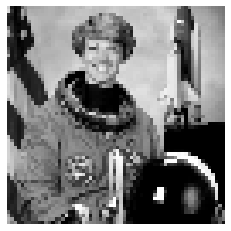

In [24]:
# grab an image
transfer_image = data.astronaut()

def gray_scale_resize(image, reshape_dim):
    # convert image to grayscale
    # same computation while we experiment
    gray_image = color.rgb2gray(image)
    
    # Resize the image down to 128x128
    resized_image = resize(gray_image, (reshape_dim, reshape_dim))
    
    return resized_image

# resize the image and put it into gray scale
resized_transfer_image = gray_scale_resize(transfer_image, resize_dim)

# batch it
reshaped_transfer_image = resized_transfer_image.reshape(-1, resize_dim, resize_dim, 1)

# display an image
show_images(reshaped_transfer_image)

### Reconstruct without normalizing against training dataset

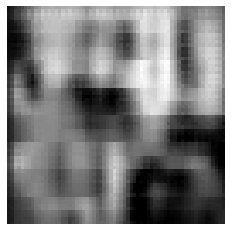

In [25]:
# reconstruct the example images
reconstructed_transfer_image = sess.run(Y, feed_dict={X: reshaped_transfer_image})

# plot them
show_images(reconstructed_transfer_image)

## 6. Examine results

We are seeing good reconstruction results although very blurry. We can see the basic shapes. 

Also, my next batch sequence should return randomized images not segments of the list.

https://stackoverflow.com/questions/40994583/how-to-implement-tensorflows-next-batch-for-own-data